# CarbonSense Exploratory Notebook

In [7]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

In [8]:
data_path = Path('data') # change if you are storing the data elsewhere

In [9]:
# List sites
sites = os.listdir(data_path)
print(sites)

['US-HB3', 'CA-Gro', 'AR-TF1', 'DE-Akm', 'US-Mo1', 'US-NR1', 'CN-Hgu', 'BE-Vie', 'US-UM3', 'CG-Tch', 'IT-MBo', 'AU-Dry', 'US-MOz', 'US-NC3', 'CH-Aws', 'FR-FBn', 'US-CS1', 'AT-Neu', 'US-KS2', 'US-StJ', 'AR-Vir', 'SE-Ros', 'US-xDL', 'IT-Isp', 'BW-Gum', 'CA-SF2', 'US-GBT', 'ZM-Mon', 'US-Jo1', 'US-CS3', 'CA-Ca2', 'US-Tw4', 'US-DPW', 'BE-Maa', 'DE-SfN', 'US-Rwf', 'US-UMB', 'US-Ro6', 'US-LA2', 'CH-Cha', 'US-HRA', 'CZ-KrP', 'DK-Sor', 'CH-Oe2', 'BR-Sa3', 'AU-Wac', 'CA-ARF', 'DE-Lnf', 'CA-Ca1', 'CN-Dan', 'DE-Lkb', 'CH-Dav', 'US-IB2', 'CN-Du2', 'IT-La2', 'IE-Cra', 'DE-Har', 'US-A74', 'US-Snd', 'ES-Agu', 'US-xDJ', 'US-BRG', 'GL-Dsk', 'US-Rls', 'IT-BCi', 'US-Jo2', 'US-SRS', 'CA-NS3', 'FR-Gri', 'US-RGB', 'US-Srr', 'AU-Whr', 'US-KS1', 'NZ-Kop', 'CA-MA3', 'US-Var', 'CZ-wet', 'US-ORv', 'IT-SR2', 'US-ONA', 'CA-NS5', 'DE-RuR', 'US-Bes', 'US-BZS', 'US-Hn2', 'IT-Cp2', 'US-Wi3', 'US-Ses', 'US-PFa', 'US-Goo', 'US-Pnp', 'US-MAC', 'US-Wi5', 'US-Ho2', 'CH-Oe1', 'US-AR1', 'ES-LgS', 'DE-Msr', 'US-xUN', 'BE-Bra',

In [10]:
# List variables
site = 'DE-Akm'
assert site in sites
site_data = pd.read_csv(data_path / site / 'data.csv', index_col='timestamp')
columns = [c for c in site_data if '_QC' not in c]
qc_columns = [c for c in site_data if '_QC' in c]
print(columns)

['DOY', 'TOD', 'TA', 'P', 'RH', 'VPD', 'PA', 'CO2', 'SW_IN', 'SW_IN_POT', 'SW_OUT', 'LW_IN', 'LW_OUT', 'NETRAD', 'PPFD_IN', 'PPFD_OUT', 'WS', 'WD', 'USTAR', 'SWC_1', 'SWC_2', 'SWC_3', 'SWC_4', 'SWC_5', 'TS_1', 'TS_2', 'TS_3', 'TS_4', 'TS_5', 'WTD', 'G', 'H', 'LE', 'NEE', 'GPP_DT', 'GPP_NT', 'RECO_DT', 'RECO_NT', 'FCH4']


### A note on variables
The variables in CarbonSense follow Ameriflux standards pretty closely, with a few notable exception:
1. Day of year (`DOY`) and time of day (`TOD`) have been added to assist with modelling
2. The variable source (observed vs reanalysis vs modelled) has been relegated entirely to the variable's QC column. QC columns are discussed further in later cells.
3. All sites contain a column for all variables, even if the entire variable is `null`. For example, all sites now have a methane column (`FCH4`), even though fewer than 100 sites have anything in it. This standardization makes post-processing much easier.

In [11]:
# Viewing a single site
print(f'Site: {site}\n')
variables_to_view = ['DOY', 'TOD', 'TA', 'TA_QC', 'LW_IN', 'LW_IN_QC', 'NEE']
print(site_data[variables_to_view])

Site: DE-Akm

                DOY   TOD     TA  TA_QC    LW_IN  LW_IN_QC       NEE
timestamp                                                           
200901010000    0.0   0.0 -2.753    2.0  279.742       2.0  0.968218
200901010030    0.0   0.5 -2.637    2.0  279.742       2.0  1.038900
200901010100    0.0   1.0 -2.521    2.0  293.777       2.0  0.941447
200901010130    0.0   1.5 -2.265    2.0  293.777       2.0  0.874287
200901010200    0.0   2.0 -2.009    2.0  293.777       2.0  0.885476
...             ...   ...    ...    ...      ...       ...       ...
202012312130  365.0  21.5  1.860    2.0  294.580       2.0 -0.920000
202012312200  365.0  22.0  1.790    2.0  298.280       2.0 -0.920000
202012312230  365.0  22.5  1.850    2.0  302.580       2.0 -0.920000
202012312300  365.0  23.0  2.100    2.0  310.410       2.0 -2.675000
202012312330  365.0  23.5  1.950    2.0  316.240       2.0 -2.475000

[210384 rows x 7 columns]


### Missing Variables and QC Flags
CarbonSense pulls from several different underlying networks (Ameriflux, ICOS, FLUXNET, and FLUXNET-CH4 so far). The QC flags can sometimes be used slightly differently, and there will often be duplicate columns indicating a strictly observed variable vs one which has been gapfilled, or even reanalysis data.

We combine observations for simplicity, as our downstream tasks are deep learning focused. This means adding a bit of noise is worth it if we can massively increase the available data points. So our QC flags represent a "worst case" scenario for each observation.

- A QC flag of 0 indicates an observed value (or a flux partitioned *from an obesrved value*).
- A QC flag of 1 indicates the variable *may* be gapfilled with high confidence
- A QC flag of 2 indicates the variable *may* be gapfilled with medium confidence
- A QC flag of 3 indicates the variable *may* be gapfilled with low confidence

This distinction is important, since some releases will give `_F` or `_MDS` gapfilled variables that are mixed in with observed values. For this reason, a variable with a QC flag of 2 may be gapfilled with medium confidence, or it may be an observed variable that was thrown in with gapfilled values.

So when we train models on CarbonSense, we use QC values >= 2 for predictors, and == 0 for fluxes. We find this leads to the strongest performance.

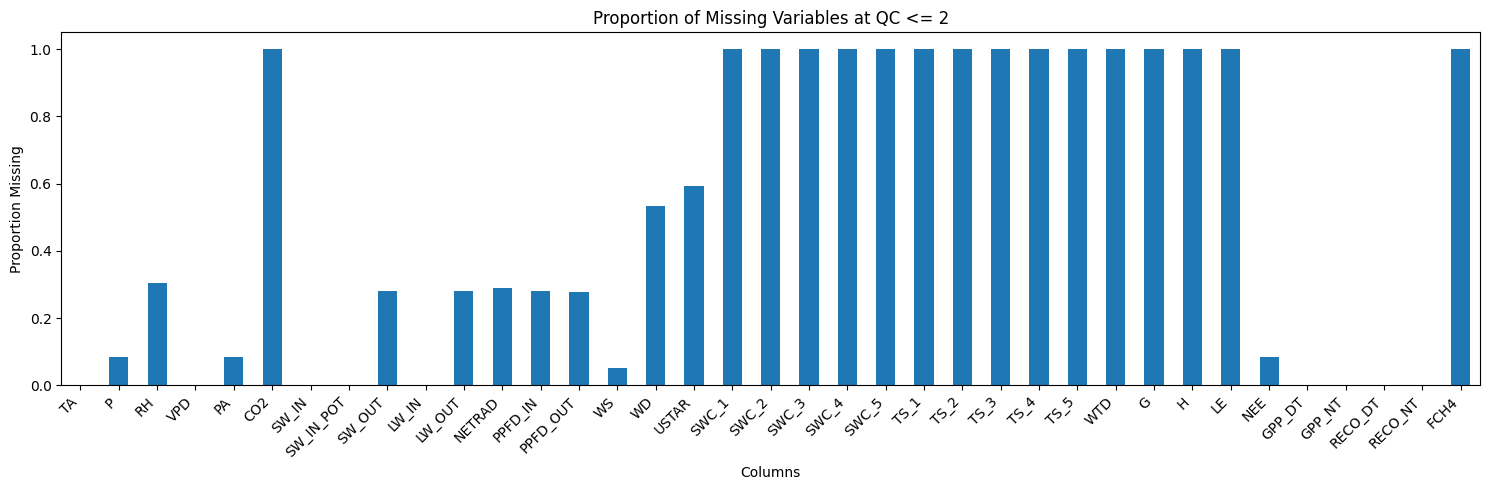

In [12]:
max_qc = 2

non_temporal_columns = [c for c in columns if c not in ['DOY', 'TOD']]
df = site_data[non_temporal_columns + qc_columns].copy()
for c in non_temporal_columns:
    df.loc[df[f'{c}_QC'] > max_qc, c] = np.nan

df2 = df[non_temporal_columns].isnull().sum() / len(df)

plt.figure(figsize=(15, 5))
df2.plot.bar()
plt.title(f'Proportion of Missing Variables at QC <= {max_qc}')
plt.xlabel("Columns")
plt.ylabel("Proportion Missing")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### MODIS Imagery
A big part of CarbonSense is multimodality. We provide MODIS images in a 4x4 square centered on each site. It's stored as direct binary data; each site subdirectory contains a `modis.pkl` file. This pickle file contains a dictionary, where each key is a timestamp and each corresponding value is the MCD43A2 + MCD43A4 data as a numpy array. Bands 1-7 are NADIR surface reflectance, band 8 is water cover, and band 9 is snow cover.

We can open these up and visualize them directly as is done here:

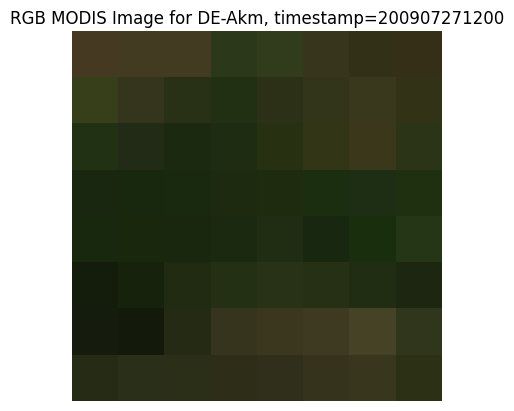

In [13]:
modis_file = data_path / site / 'modis.pkl'
with open(modis_file, 'rb') as f:
    modis_data = pkl.load(f)
date = list(modis_data.keys())[200]
modis = modis_data[date]

# pull out RGB bands and brighten them for demonstration purposes
rgb = np.stack([modis[0], modis[3], modis[2]], axis=-1) * 2.5

plt.imshow(rgb)
plt.title(f'RGB MODIS Image for {site}, timestamp={date}')
plt.axis('off')  # Optional: hides axis ticks
plt.show()